## Fig 3(b)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc


# let's import all of the packages that we will need in the notebook

from scipy.sparse import find
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import multiprocessing

from scipy.stats import gaussian_kde

import anndata as ad

import matplotlib
import seaborn as sns

from queryCO import CellOntologyQuery,DendrogramQuery

import random
COquery = CellOntologyQuery()
from tqdm import tqdm

### Computing cell ontology distances

In [2]:
def new_donors(ad):
    # add donors and then filter
    ad.obs["donor_num"] = ad.obs["donor"].str.split("TSP", expand=True)[1].astype(int)
    return ad[ad.obs["donor_num"] > 15]

In [3]:
## adata = sc.read_h5ad("/dfs/user/yhr/snap/UCE/new_tabula_sapiens_ep_8_sn_251656_nlayers_4_sample_size_1024_proc.h5ad")

## 33 layer model
adata = sc.read_h5ad("/dfs/project/cross-species/uce/new_tabula_sapiens_ep_8_sn_2013249_nlayers_33_sample_size_1024.h5ad")


In [4]:
tabula_uce = sc.AnnData(adata.obsm['X_uce'])
tabula_uce.obs = adata.obs
tabula_uce = new_donors(tabula_uce)
adata = tabula_uce

In [5]:
# Some of the cells that show up in the analysis were not included in "/dfs/project/cross-species/yanay/data/tabula/cl.obo.txt"
# which was used to build the CellOntologyQuery object.
# We are removing such cells from our dataset

filter_out = []
for idx,coc in enumerate(adata.obs["cell_ontology_class"].unique()):

    if coc not in COquery.cell2node:         # if cell is not included in cell2node dictionary we have no information about it!
        filter_out.append(coc)
        
print("Number of cells before filtration ",adata.X.shape[0])
adata = adata[~adata.obs["cell_ontology_class"].isin(filter_out)]
print("Number of cells after filtration ",adata.X.shape[0])

Number of cells before filtration  581430
Number of cells after filtration  552884


In [6]:
# copy data for faster lookups

dX = adata.X.copy()
numData = dX.shape[0]

In [7]:
#### embedding distance to CO tree distance correlation
numSmpl = 100000

In [8]:
nodeDist = []
treeDist = []
tissueList = []

In [9]:
for i in tqdm(range(numSmpl), total=numSmpl):
    p1,p2 = random.sample(range(0, numData), 2)
    if adata.obs["cell_ontology_class"][p1] == adata.obs["cell_ontology_class"][p2]:
        continue
    treeD = COquery.dist(adata.obs["cell_ontology_class"][p1],adata.obs["cell_ontology_class"][p2])
    nodeD = np.linalg.norm(dX[p1]-dX[p2])
    
    nodeDist.append(nodeD)
    treeDist.append(treeD)
    tissueList.append(adata.obs["tissue"][p1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 13386.38it/s]


In [19]:
df2s = pd.DataFrame(np.array([nodeDist, treeDist,tissueList]).T)
df2s= df2s.rename(columns={0:'node_dist', 1:'tree_dist',2:'tissue'})
df2s['tree_dist']= df2s['tree_dist'].astype('string')
df2s['node_dist']= df2s['node_dist'].astype('float32')
df2s

,node_dist,tree_dist,tissue
0,1.228943,10,Small_Intestine
1,1.192542,8,Uterus
2,1.167350,5,Mammary
3,0.992939,3,Tongue
4,1.297646,7,Blood
...,...,...,...
94483,1.151772,8,Lymph_Node
94484,1.403172,7,Lymph_Node
94485,1.227888,3,Stomach
94486,0.951774,4,Eye


In [20]:
df2s.to_csv('CL_plot_df.csv')

### Plotting CL

In [2]:
df2s = pd.read_csv('CL_plot_df.csv', index_col=0)

In [3]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [4]:
df2s['tree_dist'] = df2s['tree_dist'].astype('int')

In [5]:
#df2s = df2s[df2s['tree_dist']]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


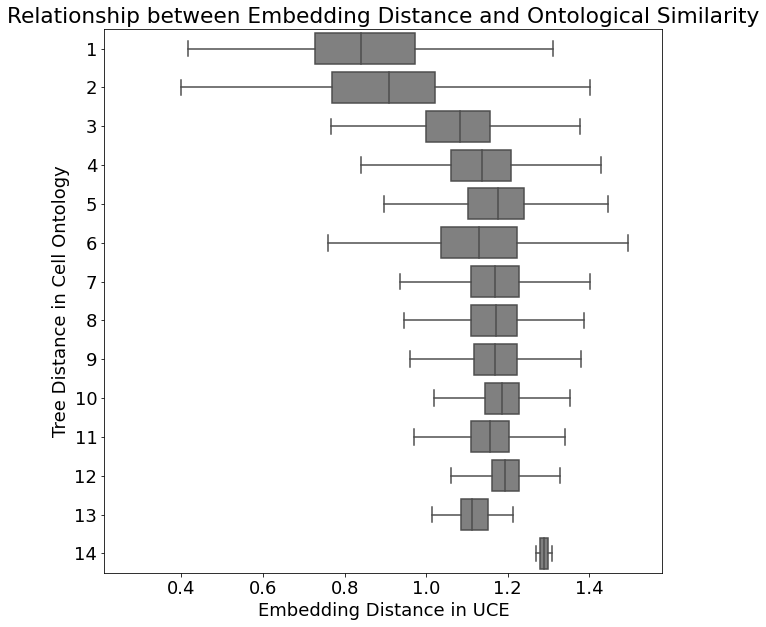

In [6]:
df2s['tree_dist'] = df2s['tree_dist'].astype('int')
#plot_df = df2s[df2s["tissue"] == 'Lymph_Node'].sort_values('tree_dist')
plot_df = df2s.sort_values('tree_dist')
plot_df['tree_dist'] = plot_df['tree_dist'].astype('str')
plt.figure(figsize=[10,10])
sns.boxplot(data=plot_df,x="node_dist",y="tree_dist", color='gray', fliersize=0).set(title = 'All Tissues')

plt.ylabel('Tree Distance in Cell Ontology')
plt.xlabel('Embedding Distance in UCE')

plt.title('Relationship between Embedding Distance and Ontological Similarity')
plt.savefig('cell_ont_complete.svg')

#plt.xlim([0, 1.3])

In [ ]:
from scipy.stats import ttest_ind

In [40]:
ttest_ind(df2s[df2s['tree_dist']==6]['node_dist'].values, df2s[df2s['tree_dist']==7]['node_dist'].values)

Ttest_indResult(statistic=-26.12566702193283, pvalue=7.0271717344470775e-149)

In [14]:
plot_df['tree_dist'] = plot_df['tree_dist'].astype(int)
plot_df_subset = plot_df[plot_df['tree_dist']<6]

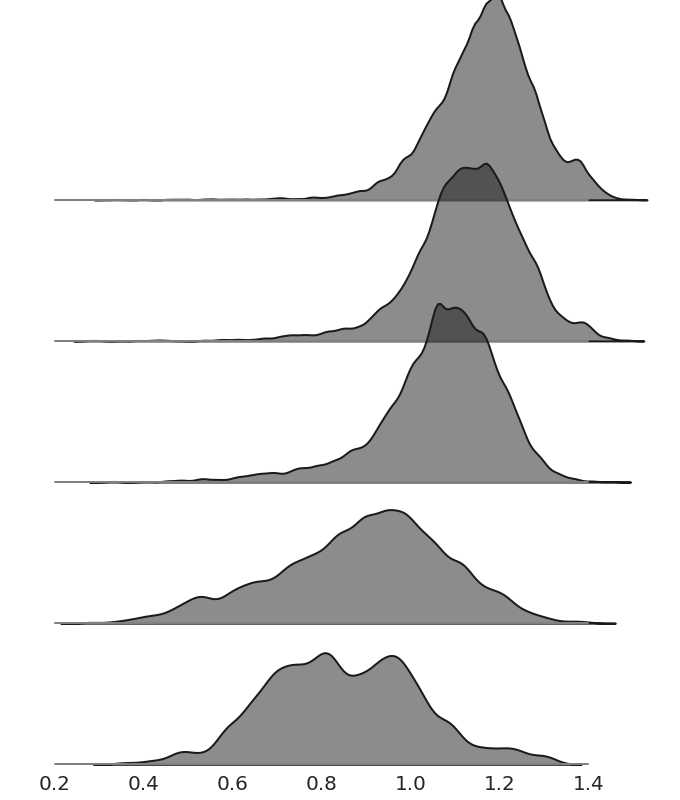

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color to a single shade of gray
gray_palette = ["gray"]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object with reversed row_order
g = sns.FacetGrid(plot_df_subset, row="tree_dist", hue="tree_dist", 
                  aspect=4, height=2., palette=gray_palette,
                  row_order=sorted(plot_df_subset['tree_dist'].unique(), reverse=True))

# Draw the densities in a few steps
g.map(sns.kdeplot, "node_dist", bw_adjust=1.5, clip_on=False, fill=False, alpha=0, lw=0)
g.map(sns.kdeplot, "node_dist", clip_on=False, color="k", fill=True, lw=2, bw_adjust=.5, alpha=0.5)
#g.map(sns.kdeplot, "node_dist", clip_on=False, color="w", fill=True, lw=2, bw_adjust=.5, alpha=0)

g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

#g.map(label, "node_dist")

ax = plt.gca()
ax.set_xlim(0.2, 1.4)  # Set x-axis limits
ax.set_ylim(0, 1.9)

# Loop through the axes to set the xtick font size
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_fontsize(20) 

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], xlabel="", ylabel="")
g.despine(bottom=True, left=True)
#plt.show()
plt.savefig('fig3b.svg')